<a href="https://colab.research.google.com/github/MrMartinMLB/TFG/blob/main/Aumentaci%C3%B3n_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libreria

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import PIL
from PIL import Image
import random
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

torch.manual_seed(123)
random.seed(123)

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


In [2]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-d1quv0rj
  Running command git clone --filter=blob:none --quiet https://github.com/aleju/imgaug /tmp/pip-req-build-d1quv0rj
  Resolved https://github.com/aleju/imgaug to commit 0101108d4fed06bc5056c4a03e2bcb0216dac326
  Preparing metadata (setup.py) ... done


# Dataset

In [3]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)


In [2]:
# Definir transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

#transform = transforms.Compose([
#    ImgAugTransform(),
#    transforms.ToTensor()
#])


# Crear dataset personalizado de PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = ['Under', 'Over', 'Empty', 'OK']
        self.imgs = []
        
        for i, cls in enumerate(self.classes):
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.imgs.append((img_path, i))  # Añadir ruta de imagen y su label
        
        # Mezclar las imágenes antes de dividir el dataset
        random.shuffle(self.imgs)
                
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path, label = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        return img, label

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Crear el dataset personalizado
dataset = CustomDataset('/content/drive/MyDrive/DatasetTFG/labeled')

In [5]:
#Trabajamos en la GPU
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [6]:
dataset_1 = torch.utils.data.Subset(dataset, range(10000)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_1))
val_size = len(dataset_1) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_1, [train_size, val_size])

In [7]:
# Create datasets for training and validation
image_datasets = {'train': train_data, 'val': val_data}

# Create dataloaders for training and validation
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

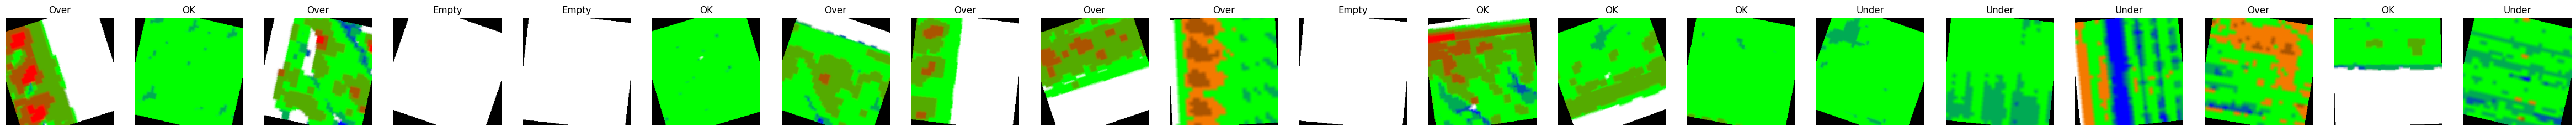

In [8]:
# Obtener un batch de datos
dataloader = torch.utils.data.DataLoader(val_data, batch_size=64,
                                         shuffle=True, num_workers=1)
images, labels = next(iter(dataloader))

# Visualizar las imágenes y etiquetas
fig, axs = plt.subplots(1, 20, figsize=(60, 20))
for i in range(20):
    axs[i].imshow(images[i].permute(1, 2, 0))
    axs[i].set_title(dataset.classes[labels[i]])
    axs[i].axis('off')
plt.show()

# Entrenar modelo

In [9]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./content/drive/MyDrive/Dataset_hymenoptera/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 11

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,val_loss_history,train_acc_history,train_loss_history

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 304MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

## Resultados para:


transform = transforms.Compose([
    transforms.Resize((78,78)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 3)),
    transforms.ToTensor(),
])

In [14]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.6996 Acc: 0.7316
val Loss: 0.6263 Acc: 0.7810

Epoch 1/10
----------
train Loss: 0.5690 Acc: 0.7860
val Loss: 0.5183 Acc: 0.8030

Epoch 2/10
----------
train Loss: 0.5195 Acc: 0.8073
val Loss: 0.4761 Acc: 0.8160

Epoch 3/10
----------
train Loss: 0.5050 Acc: 0.8103
val Loss: 0.4820 Acc: 0.8115

Epoch 4/10
----------
train Loss: 0.4801 Acc: 0.8226
val Loss: 0.4977 Acc: 0.8100

Epoch 5/10
----------
train Loss: 0.4517 Acc: 0.8349
val Loss: 0.4408 Acc: 0.8280

Epoch 6/10
----------
train Loss: 0.4464 Acc: 0.8326
val Loss: 0.4747 Acc: 0.8090

Epoch 7/10
----------
train Loss: 0.4355 Acc: 0.8374
val Loss: 0.4764 Acc: 0.8165

Epoch 8/10
----------
train Loss: 0.4330 Acc: 0.8370
val Loss: 0.4355 Acc: 0.8325

Epoch 9/10
----------
train Loss: 0.4166 Acc: 0.8400
val Loss: 0.4564 Acc: 0.8200

Epoch 10/10
----------
train Loss: 0.4067 Acc: 0.8441
val Loss: 0.4812 Acc: 0.8225

Training complete in 42m 12s
Best val Acc: 0.832500


## Resultados para:

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 3)),
    transforms.ToTensor(),
])

In [15]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.6516 Acc: 0.7512
val Loss: 0.4738 Acc: 0.8180

Epoch 1/10
----------
train Loss: 0.5196 Acc: 0.8053
val Loss: 0.4687 Acc: 0.8055

Epoch 2/10
----------
train Loss: 0.4879 Acc: 0.8129
val Loss: 0.4327 Acc: 0.8190

Epoch 3/10
----------
train Loss: 0.4656 Acc: 0.8246
val Loss: 0.4754 Acc: 0.8295

Epoch 4/10
----------
train Loss: 0.4395 Acc: 0.8351
val Loss: 0.4423 Acc: 0.8315

Epoch 5/10
----------
train Loss: 0.4356 Acc: 0.8366
val Loss: 0.4692 Acc: 0.8170

Epoch 6/10
----------
train Loss: 0.4185 Acc: 0.8379
val Loss: 0.4748 Acc: 0.8175

Epoch 7/10
----------
train Loss: 0.4107 Acc: 0.8445
val Loss: 0.4734 Acc: 0.8215

Epoch 8/10
----------
train Loss: 0.3981 Acc: 0.8473
val Loss: 0.4389 Acc: 0.8250

Epoch 9/10
----------
train Loss: 0.3852 Acc: 0.8553
val Loss: 0.4856 Acc: 0.8145

Epoch 10/10
----------
train Loss: 0.3634 Acc: 0.8585
val Loss: 0.4716 Acc: 0.8215

Training complete in 24m 28s
Best val Acc: 0.831500


## Ningun cambio:

In [13]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.6696 Acc: 0.7516
val Loss: 0.4993 Acc: 0.8090

Epoch 1/10
----------
train Loss: 0.5069 Acc: 0.8110
val Loss: 0.4910 Acc: 0.8230

Epoch 2/10
----------
train Loss: 0.4541 Acc: 0.8320
val Loss: 0.4544 Acc: 0.8370

Epoch 3/10
----------
train Loss: 0.3984 Acc: 0.8539
val Loss: 0.4887 Acc: 0.8315

Epoch 4/10
----------
train Loss: 0.3476 Acc: 0.8641
val Loss: 0.4987 Acc: 0.8200

Epoch 5/10
----------
train Loss: 0.3183 Acc: 0.8840
val Loss: 0.5292 Acc: 0.8165

Epoch 6/10
----------
train Loss: 0.2738 Acc: 0.8964
val Loss: 0.6274 Acc: 0.7915

Epoch 7/10
----------
train Loss: 0.2467 Acc: 0.9123
val Loss: 0.6560 Acc: 0.8135

Epoch 8/10
----------
train Loss: 0.2076 Acc: 0.9270
val Loss: 0.6647 Acc: 0.8175

Epoch 9/10
----------
train Loss: 0.1848 Acc: 0.9367
val Loss: 0.6619 Acc: 0.8020

Epoch 10/10
----------
train Loss: 0.1550 Acc: 0.9469
val Loss: 0.7368 Acc: 0.8025

Training complete in 34m 35s
Best val Acc: 0.837000


## Resultados para:

  self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])

In [18]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.6481 Acc: 0.7422
val Loss: 0.5056 Acc: 0.8035

Epoch 1/10
----------
train Loss: 0.5265 Acc: 0.8005
val Loss: 0.4656 Acc: 0.8230

Epoch 2/10
----------
train Loss: 0.4803 Acc: 0.8240
val Loss: 0.5542 Acc: 0.7845

Epoch 3/10
----------
train Loss: 0.4656 Acc: 0.8281
val Loss: 0.4798 Acc: 0.8170

Epoch 4/10
----------
train Loss: 0.4489 Acc: 0.8295
val Loss: 0.4660 Acc: 0.8300

Epoch 5/10
----------
train Loss: 0.4210 Acc: 0.8434
val Loss: 0.4843 Acc: 0.8190

Epoch 6/10
----------
train Loss: 0.4135 Acc: 0.8459
val Loss: 0.5025 Acc: 0.8135

Epoch 7/10
----------
train Loss: 0.4109 Acc: 0.8448
val Loss: 0.4922 Acc: 0.8080

Epoch 8/10
----------
train Loss: 0.3979 Acc: 0.8494
val Loss: 0.4472 Acc: 0.8205

Epoch 9/10
----------
train Loss: 0.3779 Acc: 0.8574
val Loss: 0.4641 Acc: 0.8180

Epoch 10/10
----------
train Loss: 0.3688 Acc: 0.8616
val Loss: 0.5345 Acc: 0.8245

Training complete in 73m 20s
Best val Acc: 0.830000


## Resultados para: size 224 y pequeño giro 20º

In [14]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.6242 Acc: 0.7570
val Loss: 0.4955 Acc: 0.8190

Epoch 1/10
----------
train Loss: 0.5011 Acc: 0.8134
val Loss: 0.4774 Acc: 0.8225

Epoch 2/10
----------
train Loss: 0.4538 Acc: 0.8310
val Loss: 0.4703 Acc: 0.8135

Epoch 3/10
----------
train Loss: 0.4352 Acc: 0.8394
val Loss: 0.4969 Acc: 0.8125

Epoch 4/10
----------
train Loss: 0.4125 Acc: 0.8479
val Loss: 0.4798 Acc: 0.8250

Epoch 5/10
----------
train Loss: 0.3756 Acc: 0.8605
val Loss: 0.5198 Acc: 0.8200

Epoch 6/10
----------
train Loss: 0.3610 Acc: 0.8641
val Loss: 0.5622 Acc: 0.8010

Epoch 7/10
----------
train Loss: 0.3437 Acc: 0.8694
val Loss: 0.5436 Acc: 0.8030

Epoch 8/10
----------
train Loss: 0.3217 Acc: 0.8825
val Loss: 0.5081 Acc: 0.8210

Epoch 9/10
----------
train Loss: 0.2909 Acc: 0.8919
val Loss: 0.6239 Acc: 0.7965

Epoch 10/10
----------
train Loss: 0.2834 Acc: 0.8950
val Loss: 0.5948 Acc: 0.8215

Training complete in 33m 42s
Best val Acc: 0.825000


## Graf

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

In [16]:
classes = ('Under', 'Over', 'Empty', 'OK')

In [17]:
y_pred_val = []
y_true_val = []
yscore_val = []

for inputs, labels in dataloaders_dict['val']:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_val.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_val.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_val.extend(yscore)

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
yscore_val = np.array(yscore_val)

In [18]:
y_pred_train = []
y_true_train = []
yscore_train = []

for inputs, labels in dataloaders_dict['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_train.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_train.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_train.extend(yscore)

y_pred_train = np.array(y_pred_train)
y_true_train = np.array(y_true_train)
yscore_train = np.array(yscore_train)

In [19]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_true_train)
y_onehot_test = label_binarizer.transform(y_true_val)
y_onehot_test.shape  # (n_samples, n_classes)

(2000, 4)

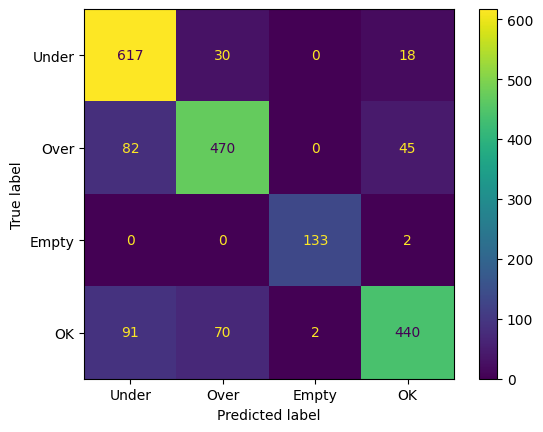

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd


# Build confusion matrix
cf_matrix = confusion_matrix(y_true_val, y_pred_val)
#df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     #columns = [i for i in classes])
disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
disp.plot()
plt.show()

In [21]:
class_dict = {0: 'Under', 1: 'Over', 2: 'Empty', 3: 'Ok'}
y_true_valnames = [(class_dict[label])
          for label in y_true_val
          if label in [0, 1, 2, 3]]

In [22]:
from itertools import combinations


pair_list = list(combinations(np.unique(y_true_val), 2))
print(pair_list)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


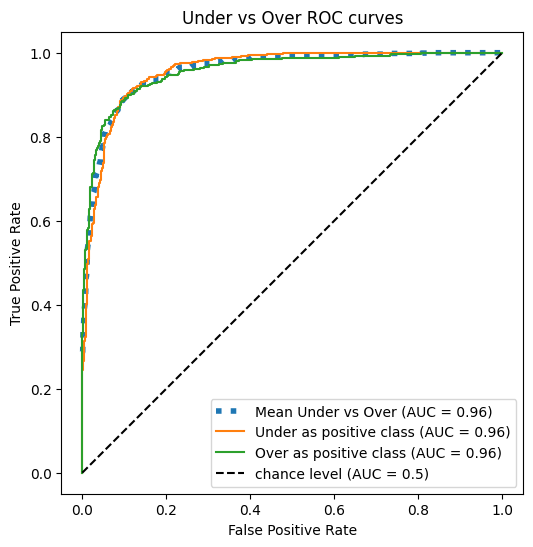

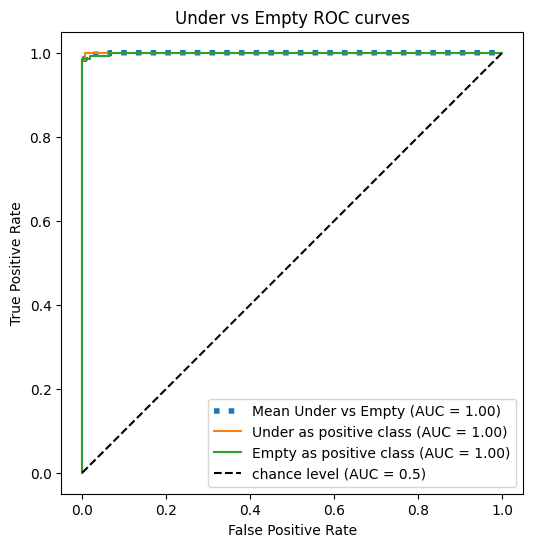

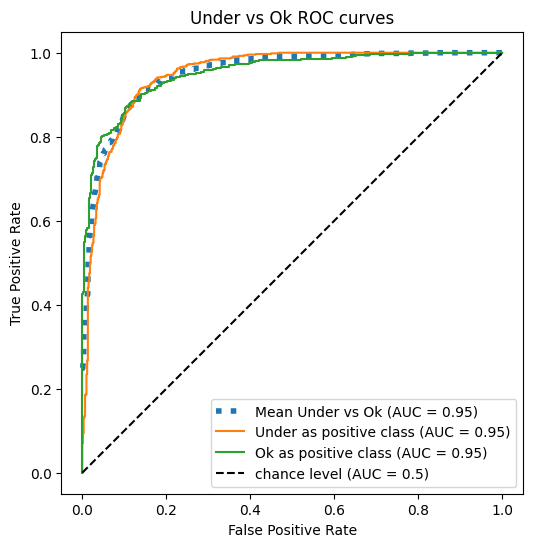

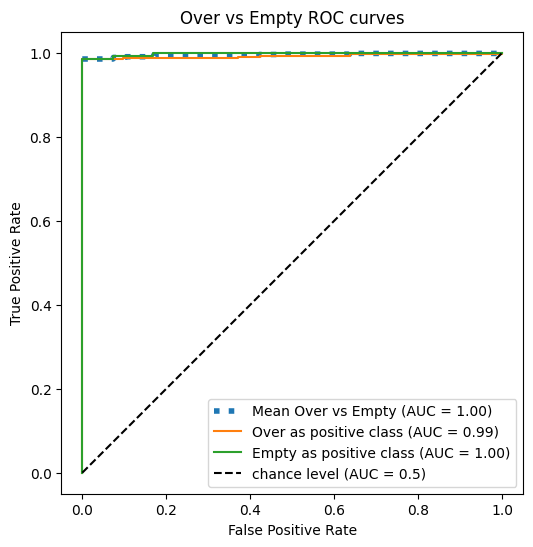

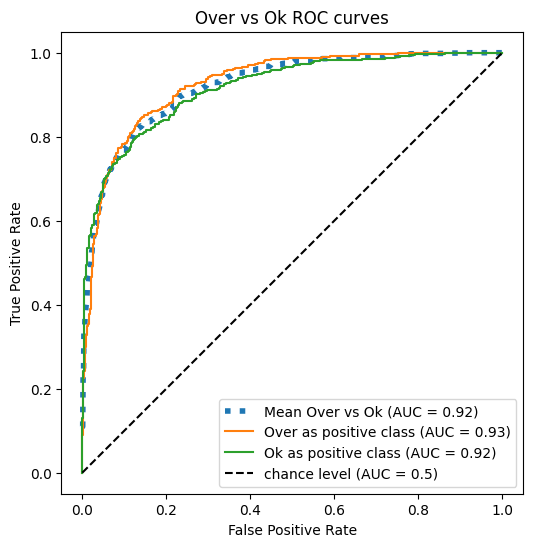

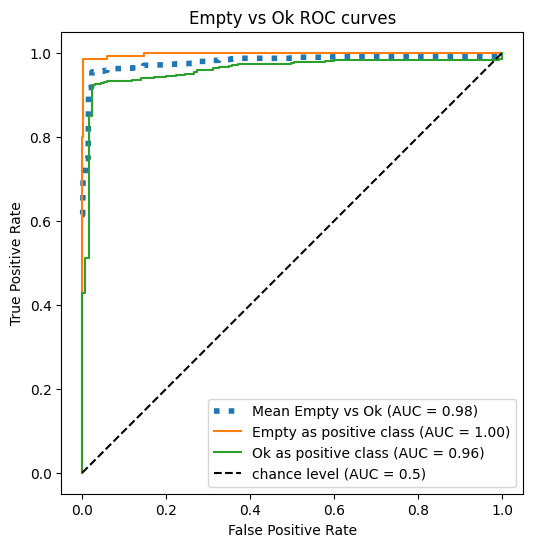

Macro-averaged One-vs-One ROC AUC score:
0.97


In [23]:
from sklearn.metrics import roc_curve, auc

pair_scores = []
mean_tpr = dict()
fpr_grid = np.linspace(0.0, 1.0, 1000)

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_true_val == label_a
    b_mask = y_true_val == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, yscore_val[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, yscore_val[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {class_dict[label_a]} vs {class_dict[label_b]} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        yscore_val[ab_mask, idx_a],
        ax=ax,
        name=f"{class_dict[label_a]} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        yscore_val[ab_mask, idx_b],
        ax=ax,
        name=f"{class_dict[label_b]} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{classes[idx_a]} vs {class_dict[label_b]} ROC curves")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")